In [1]:
# Configuration of policy-CEM-method
from yacs.config import CfgNode as CN

_C = CN()
_C.SYSTEM = CN()
_C.SYSTEM.DEVICES = []
_C.SYSTEM.VIRTUAL_SCREEN = (600, 400)
_C.SYSTEM.PRINT_EVERY = 10

_C.AGENT = CN()
_C.AGENT.MAX_N_STEPS = 500
_C.AGENT.GAMMA = 1.0
_C.AGENT.POPULATION_SIZE = 50
_C.AGENT.ELITE_FRAC = 0.2

_C.GAME_ENV = CN()
_C.GAME_ENV.N_ITERATIONS = 30
_C.GAME_ENV.NOISE_SIGMA = 0.5

def get_cfg_defaults():
    return _C.clone()

In [2]:
import gym
import os
import numpy as np
from pyvirtualdisplay import Display
from collections import deque
import torch
from collections import deque

#from cartpole.config import get_cfg_defaults
#from cartpole.utils import ReplayMemory, screen_to_state
cfg = get_cfg_defaults()

devices = ",".join(str(i) for i in cfg.SYSTEM.DEVICES)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = devices

torch_devices = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
display = Display(visible=0, size=cfg.SYSTEM.VIRTUAL_SCREEN)
display.start()
env = gym.make("CartPole-v0").unwrapped

In [4]:
env.reset()
xx = env.render(mode="rgb_array")

In [5]:
# agent.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

class Agent_PolicyCEM(nn.Module):
    def __init__(self, input_size, output_size, device="cpu"):
        super(Agent_PolicyCEM, self).__init__()
        self.device = device
        
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 64)
        self.layer3 = nn.Linear(64, output_size, bias=False)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return torch.sigmoid(self.layer3(x)) # action = 0 or 1 (discrete, cannot be continous)
    
    def get_weights_dim(self):
        # return numbers of parameters of layers --> n in flatten form
        return [len(param.reshape(-1).detach().numpy()) for param in self.parameters()]
    
    def set_weights(self, weights):
        new_network_state = self._pair_weight_key_to_weight(weights=weights)
        self.load_state_dict(new_network_state)
    
    def evaluate(self, env, weights, gamma=1.0, max_n_steps=5000):
        self.set_weights(weights)
        state = env.reset()
        rewards = 0.
        for t in range(max_n_steps):
            state = torch.from_numpy(state).float().to(self.device)
            action = self.forward(state).detach().numpy()
            action = int(np.round(action)) # cartpole-v0 only accept 0 or 1 (no float between 0-1)
            next_state, reward, done, _ = env.step(action)
            rewards += reward + gamma**t
            state = next_state
            if done:
                break
        return rewards
        
    
    def _pair_weight_key_to_weight(self, weights):
        """pair key and weights
        Args:
          weights: list of 1D-vectors n * [n_weights]
          
        Returns: A reshaped, mapped state_dict
        """
        keys = list(self.state_dict().keys())
        original_weight_shape = [list(param.shape) for param in self.parameters()]
        return OrderedDict({k:torch.from_numpy(v).reshape(s) for k, v, s in zip(keys, weights, original_weight_shape)})
        

In [6]:
agent = Agent_PolicyCEM(input_size=4, output_size=1, device=torch_devices).to(torch_devices)

In [7]:
# Start Training
n_elite=int(cfg.AGENT.POPULATION_SIZE * cfg.AGENT.ELITE_FRAC)
scores_deque = deque(maxlen=100)
scores = []
best_weight = [cfg.GAME_ENV.NOISE_SIGMA * np.random.randn(i) for i in agent.get_weights_dim()]

for i_iteration in range(1, cfg.GAME_ENV.N_ITERATIONS+1):
    weights_pop = [[best_weight[i] + (cfg.GAME_ENV.NOISE_SIGMA * np.random.randn(j)) for i,j in enumerate(agent.get_weights_dim())] \
                    for _ in range(cfg.AGENT.POPULATION_SIZE)]
    rewards = np.array([agent.evaluate(env=env, 
                                       weights=weights, 
                                       gamma=cfg.AGENT.GAMMA, 
                                       max_n_steps=cfg.AGENT.MAX_N_STEPS) for weights in weights_pop])

    elite_idxs = rewards.argsort()[-n_elite:]
    elite_weights = [weights_pop[i] for i in elite_idxs]
    best_weight = np.array(elite_weights).mean(axis=0)

    reward = agent.evaluate(env=env, weights=best_weight, gamma=cfg.AGENT.GAMMA, max_n_steps=5000)
    scores_deque.append(reward)
    scores.append(reward)

    #torch.save(agent.state_dict(), 'checkpoint.pth')

    if i_iteration % cfg.SYSTEM.PRINT_EVERY == 0:
        print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

    
print('\nFinally!\tAverage Score: {:.2f}'.format(np.mean(scores_deque)))

Episode 10	Average Score: 106.00
Episode 20	Average Score: 240.90
Episode 30	Average Score: 405.67

Finally!	Average Score: 405.67


In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [13]:
int(np.round(action))

1

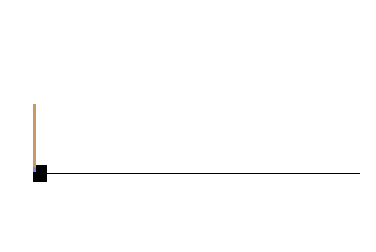

In [14]:
state = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))
while True:
    state = torch.from_numpy(state).float().to(torch_devices)
    with torch.no_grad():
        action = agent(state)
    action = int(np.round(action))
    img.set_data(env.render(mode='rgb_array')) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    next_state, reward, done, _ = env.step(action)
    state = next_state
    if done:
        break

env.close()